<a href="https://colab.research.google.com/github/pawan-cpu/Learn-Python-with-Pawan-Kumar/blob/main/L19Jan__2022_01_19_pawan_lesson57.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 57: Variance Inflation Factor


|Particulars|Description|
|-|-|
|**Topics Covered**|Variance Inflation Factor|
||Rebuilding Linear Regression Model|
|||
|**Lesson Description**|In this class, a student learns to calculate the variance inflation factor (VIF) values to measure the extent of multicollinearity in multiple linear regression.|
|||
|**Lesson Duration**|50 minutes|
|||
|**Learning Outcomes**|Calculate the VIF values using the `variance_inflation_factor` function of the `statsmodels.stats.outliers_influence` module.|
||Calculate the VIF values using the $\frac{1}{1 - R^2}$ formula.|



---

### Teacher-Student Tasks

In the previous class, you built a linear regression model again to predict the relative humidity values from the temperature and ozone values. However, you again got `The condition number is large, 3.89e+03. This might indicate that there are strong multicollinearity or other numerical problems.` message after removing the chances of multicollinearity from the model.

In this class, you will learn how to measure the extent of multicollinearity in a multiple linear regression model by calculating the variance inflation factor values for each independent variable. This exercise will enable you to select the features (or independent variables) that predicts the values of the dependent variable best. In machine learning discourse, this exercise is called **feature selection** or **feature elimination**. VIF is one of the ways to select or eliminate features to build a good linear regression model.

Let's quickly run the codes covered in the previous classes and begin this session from **Task 1: Variance Inflation Factor** section.

---

In [ ]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1) 

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int64         
 11  Month          9357 non-null   int64         
 12  Day            9357 non-null   int64         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.1+

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

---

#### Multiple Linear Regression Model Using `sklearn` Module


In [ ]:
# Build a linear regression model using the sklearn module by including all the features listed above.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

features = list(df.columns.values[1:-1])
features.remove('RH')

X = df[features]
y = df['RH']

# Splitting the DataFrame into the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Build a linear regression model using the 'sklearn.linear_model' module.
sklearn_lin_reg = LinearRegression()
sklearn_lin_reg.fit(X_train, y_train_reshaped)

# Print the value of the intercept i.e. beta-sub-0.
print("\nConstant".ljust(15, " "), f"{sklearn_lin_reg.intercept_[0]:.6f}") # Soon you will get to know why rounding-off to 6 decimal places.

# Print the names of the features along with the values of their corresponding coefficients.
for item in list(zip(X.columns.values, sklearn_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.6f}") # Soon you will get to know why rounding-off to 6 decimal places.


Constant       -15028.451823
PT08.S1(CO)     0.014833
C6H6(GT)        -0.903464
PT08.S2(NMHC)   -0.005881
PT08.S3(NOx)    0.001503
PT08.S4(NO2)    0.026497
PT08.S5(O3)     -0.001066
T               -2.354919
AH              29.551742
Year            7.505153
Month           1.167861
Day             0.035232


In [ ]:
# Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = sklearn_lin_reg.predict(X_train)
y_test_pred = sklearn_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")
      
print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 35.116
Root Mean Squared Error: 5.926
Mean Absolute Error: 4.572


Test Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 34.702
Root Mean Squared Error: 5.891
Mean Absolute Error: 4.564


---

#### The `statsmodels.api` Module

In [ ]:
# Build a linear regression model using the 'statsmodels.api' module.
import statsmodels.api as sm

# Create data frames for the features and target again and also split them into the train and test sets.
X = df[features]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

# Add a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr.params

const           -15028.451823
PT08.S1(CO)          0.014833
C6H6(GT)            -0.903464
PT08.S2(NMHC)       -0.005881
PT08.S3(NOx)         0.001503
PT08.S4(NO2)         0.026497
PT08.S5(O3)         -0.001066
T                   -2.354919
AH                  29.551742
Year                 7.505153
Month                1.167861
Day                  0.035232
dtype: float64

The above values for the constant and the coefficients of all the features are almost the same as the ones obtained through the `sklearn` linear regression model.

In [ ]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:52:31   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

---

#### Multicollinearity

In [ ]:
# Print the summary of the multiple linear regression model built earlier.
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:52:31   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

Multicollinearity is a situation where the independent variables or features are correlated to each other. Ideally, only the dependent variable (or target) should be correlated with the independent variables and the independent variables should not be correlated with each other at all. 


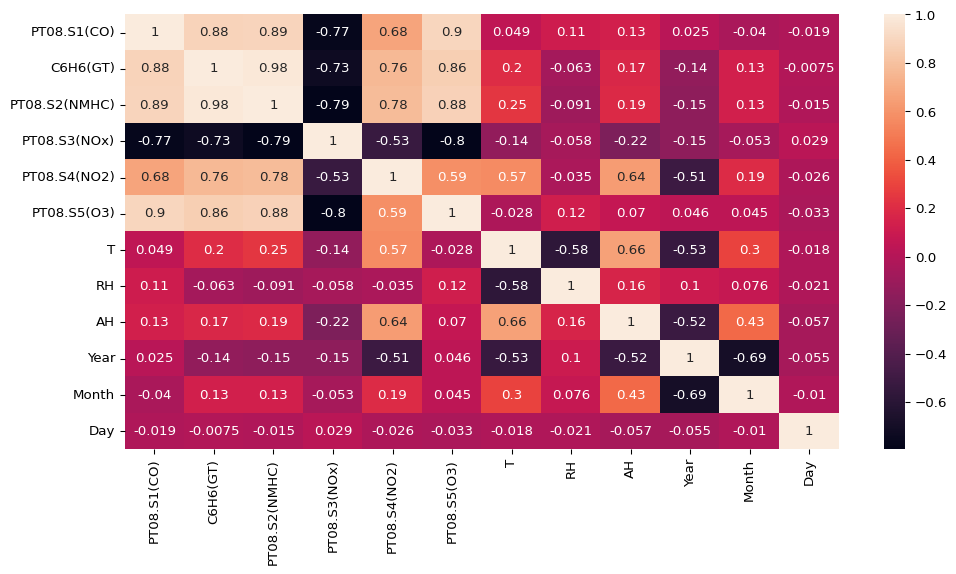

In [ ]:
# Create a heatmap of a correlation DataFrame of the air quality analysis dataset to understand this concept better.
plt.figure(figsize = (12, 6), dpi = 96)
sns.heatmap(df.corr(), annot = True)
plt.show()

From the heatmap, you can see that, the dependent variable `RH` is moderately correlated with `T` and weakly correlated with carbon monoxide (`'PT08.S1(CO)'`), ozone (`'PT08.S5(O3)'`) , absolute humidity (`AH`) and year (`Year`).

Ideally, to build a multiple linear regression model to predict relative humidity, we should have considered carbon monoxide, ozone, absolute humidity and year independent variables only instead of considering all the independent variables. But among these 4 features: 

- carbon monoxide and ozone are strongly correlated to each other.

- temperature and absolute humidity are moderately correlated to each other.

- temperature and year are moderately correlated to each other.

- absolute humidity and year are moderately correlated to each other.

The above four cases are examples of multicollinearity wherein the independent variables are correlated to each other.


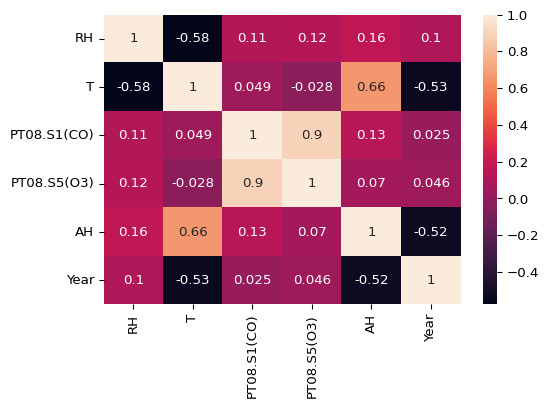

In [ ]:
# Create a correlation heatmap between 'RH', 'T', 'PT08.S1(CO)', 'PT08.S5(O3)', 'AH', 'Year' variables.
plt.figure(figsize = (6, 4), dpi = 96)
sns.heatmap(df[['RH', 'T', 'PT08.S1(CO)', 'PT08.S5(O3)', 'AH', 'Year']].corr(), annot = True)
plt.show()

This multicollinearity causes redundancy because of which we cannot say for sure which of the independent variables are actually contributing to the prediction of the dependent variable.

In this case, to remove multicollinearity, 

- Choose either `T` or `AH` as one of the independent variables. Since the correlation between `RH` and `T` is stronger compared to the correlation between `RH` and `AH`, let's choose `T`.

- Choose either `'PT08.S1(CO)'` or `'PT08.S5(O3)'` as one of the independent variables. Since the correlation between `RH` and `PT08.S5(O3)` is stronger compared to the correlation between `RH` and `'PT08.S1(CO)'`, let's choose `PT08.S5(O3)`.

- Drop `Year` as it is moderately correlated with `'T'`.


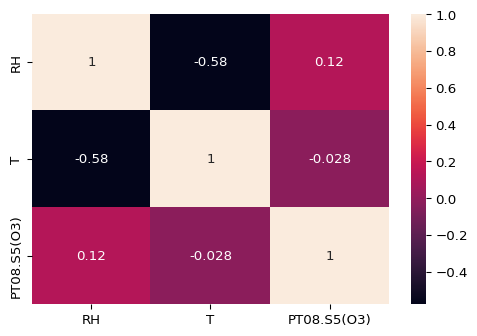

In [ ]:
# Create a correlation heatmap between 'RH', 'T', 'PT08.S5(O3)' variables.
plt.figure(figsize = (6, 4), dpi = 96)
sns.heatmap(df[['RH', 'T', 'PT08.S5(O3)']].corr(), annot = True)
plt.show()

Now that we have removed multicollinearity and selected the features that are likely to contribute best to the prediction of relative humidity values, let's build a linear regression model again using the `statsmodels.api` module.

In [ ]:
# Build a linear regression model again with 'T' and 'PT08.S5(O3)' as independent variables to predict 'RH'.
X_train = X_train[['T', 'PT08.S5(O3)']]
X_test = X_test[['T', 'PT08.S5(O3)']]

# Add a constant to get an intercept
X_train_sm1 = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
lr1 = sm.OLS(y_train, X_train_sm1).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr1.params

const          64.956429
T              -1.104251
PT08.S5(O3)     0.004509
dtype: float64

Let's now print the summary table as well.

In [ ]:
df['PT08.S5(O3)'].std() / np.sqrt(df['PT08.S5(O3)'].mean())
print(df['T'].std() / np.sqrt(df['T'].mean()))

2.0457658646316825


In [ ]:
# Print the summary table to get all the parameters for the features used to build a linear regression model.
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1580.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:52:33   Log-Likelihood:                -25378.
No. Observations:                6269   AIC:                         5.076e+04
Df Residuals:                    6266   BIC:                         5.078e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9564      0.623    104.206      

---

#### Task 1: Variance Inflation Factor Math

Variance Infation Factor (VIF) is a way to detect multicollinearity between independent variables in a dataset. We calculate the VIF values to measure the extent of multicollinearity between the independent variables.  

For $k$ different independent variables, we can calculate $k$ different VIFs (one for each $x_i$ where $i = 1, 2, 3, \dots, k$) in three steps:

**Step one**

First, build a multiple linear regression model wherein $x_i$ is a target variable and it is a function of all the other feature variables as illustrated in the equation below.

$$x_1 = \beta_0^* + \beta_2^* x_2 + \beta_3^* x_3 + \beta_4^* x_4 + \dots + \beta_k^* x_k + \epsilon^*$$

Here,

- $x_1$ is a feature acting as the target (or dependent) variable in above equation

- $x_2, x_3, x_4, \dots , x_k$ are independent variables or features

- $\beta_0^*, \beta_2^*, \beta_3^*, \dots, \beta_k^*$ are the corresponding regression coefficients of the independent variables in the above linear regression equation

- **$\epsilon^*$** is the random error obtained along with the predicted value

**Step two**

Then, calculate the VIF for $x_{i}$ using the following formula:

$$\text{VIF}_{i} = \frac{1}{1-R_{i}^{2}}$$

where $R^2 _i$ is the coefficient of determination of the regression equation in step one, with $x_{1}$ on the left hand side, and all other independent variables on the right hand side.

**Step three**

Analyse the extent of multicollinearity by considering the magnitude of the $\text{VIF}_{i}$. **A rule of thumb is that if $\text{VIF}_{i} > 10$, then multicollinearity is high. In that case, the $x_i$ feature must be dropped to predict the values of the target (or dependent) variable.** A cutoff of 5 is also commonly used.

Let's learn this concept with the help of an example. Let's build a linear regression model to predict relative humidity values from `T` and `PT08.S5(O3)`	values. Let's add one more feature say `'PT08.S1(CO)'` to the prediction model because ozone and carbon monoxide are highly correlated to each other and relative himidity is correlated to carbon monoxide as well.

Then we will calculate the VIF values for `T, PT08.S5(O3)` and `'PT08.S1(CO)'` independent variables first using the `variance_inflation_factor` function of the `statsmodels.stats.outliers_influence` module and then using $\frac{1}{1 - R^2}$ formula.


In [ ]:
X = df[['T', 'PT08.S5(O3)', 'PT08.S1(CO)']]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Add a constant to get an intercept
X_train_sm2 = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
lr2 = sm.OLS(y_train, X_train_sm2).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr2.params

const          53.560416
T              -1.141346
PT08.S5(O3)    -0.005377
PT08.S1(CO)     0.020191
dtype: float64

In [ ]:
# S1.2: Print the summary table for the above linear regression model.
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     1111.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:52:33   Log-Likelihood:                -25322.
No. Observations:                6269   AIC:                         5.065e+04
Df Residuals:                    6265   BIC:                         5.068e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          53.5604      1.233     43.454      

Now let's calculate the VIF values for `'T', 'PT08.S5(O3)'` and `'PT08.S1(CO)'` independent variables using the `variance_inflation_factor` function of the `statsmodels.stats.outliers_influence` module.

In [ ]:
# S1.3: Calculate the VIF values for 'T', 'PT08.S5(O3)' and 'PT08.S1(CO)' independent variables using the 'variance_inflation_factor' function.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_sm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm2.values, i) for i in range(X_train_sm2.values.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,50.42
2,PT08.S5(O3),5.29
3,PT08.S1(CO),5.29
1,T,1.03


As you can see the VIF values for `const` is very high.

Let's learn how to calculate the VIF values using the $\frac{1}{1 - R^2}$ formula. But before that, let's build a linear regression model again taking ozone as the dependent variable and temperature and carbon monoxide as the independent variables. Then calculate the $R^2$ value for this model.

In [ ]:
# S1.4: Build a linear regression model taking 'PT08.S5(O3)' as the target and 'T' and 'PT08.S1(CO)' as the independent variables.
ozone_X_train = X_train[['T', 'PT08.S1(CO)']]
ozone_y_train  = X_train['PT08.S5(O3)']



# Add a constant to get an intercept
ozone_X_train_sm2 = sm.add_constant(ozone_X_train)

# Fit the regression line using 'OLS'
ozone_lr2 = sm.OLS(ozone_y_train, ozone_X_train_sm2).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
print(ozone_lr2.summary())

                            OLS Regression Results                            
Dep. Variable:            PT08.S5(O3)   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                 1.344e+04
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:52:33   Log-Likelihood:                -41052.
No. Observations:                6269   AIC:                         8.211e+04
Df Residuals:                    6266   BIC:                         8.213e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -735.6783     11.968    -61.473      

In [ ]:
# S1.5: Calculate the VIF value for ozone where ozone is the dependent variable.
ozone_vif=1/(1-0.811)
ozone_vif

5.291005291005293

Now, let's repeat the above two exercises to calculate the VIF value for `T` independent variable using the $\frac{1}{1 - R^2}$ variable.

In [ ]:
# S1.6: Build a linear regression model taking 'T' as the target and 'T' and 'PT08.S1(CO)' and 'PT08.S5(O3)' as the independent variables.
temp_X_train = X_train[['PT08.S5(O3)', 'PT08.S1(CO)']]
temp_y_train  = X_train['T']



# Add a constant to get an intercept
temp_X_train_sm2 = sm.add_constant(temp_X_train)

# Fit the regression line using 'OLS'
temp_lr2 = sm.OLS(temp_y_train, temp_X_train_sm2).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
print(temp_lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                      T   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     99.88
Date:                Wed, 19 Jan 2022   Prob (F-statistic):           2.00e-43
Time:                        09:52:33   Log-Likelihood:                -22368.
No. Observations:                6269   AIC:                         4.474e+04
Df Residuals:                    6266   BIC:                         4.476e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.4571      0.760     12.442      

In [ ]:
# S1.7: Calculate the VIF value for temperature where temperature is the dependent variable.
1/(1-0.031)

1.0319917440660475

Hence we have got the value of the variance inflation factor as 1.032 for the depended variable i.e. temperature which indicates that the multicollinearity is very less.

---

#### Task 2: Calculating VIFs for Previously Built Model

Now let's calculate the VIF values for the independent variables in the linear regression model that you built in the previous class.

In [ ]:
# S2.1: Calculate the VIF values for the independent variables in the linear regression model built in the previous class.
vif = pd.DataFrame()
vif['Features'] = X_train_sm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm1.values, i) for i in range(X_train_sm1.values.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs


,Features,VIF
0,const,12.67
1,T,1.00
2,PT08.S5(O3),1.00


Here, the `const` (short for **constant**) is an additional feature that we add before building a linear regression module. It has all the values as $1$. So, `const` is causing multicollinearity. 

Ideally, we should drop `const` because the VIF value for it is greater than 10. But we cannot drop it, because using this feature we get the $\beta_0$ value. 

So now let's look at the final linear regression model that we have built after selecting the final features that are supposed to predict the relative humidity values.




In [ ]:
# S2.2: Print the summary table for the linear regression model built in the previous class by taking 'T' and 'PT08.S5(O3)' as features.
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1580.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:57:00   Log-Likelihood:                -25378.
No. Observations:                6269   AIC:                         5.076e+04
Df Residuals:                    6266   BIC:                         5.078e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9564      0.623    104.206      

Hence, to predict relative humdity values, the final linear regression model that you get after going through so much effort is

$$\text{relative humidity} = 64.9564 - 1.1043 \space{} \text{temperature} + 0.0045 \space{} \text{ozone}$$

or

$$\text{RH} = 64.9564 - 1.1043 \space{} \text{T} + 0.0045 \space{} \text{O}_3$$

You can create a function that can predict relative humdity values using the temperature and ozone values.

In [ ]:
# S2.3: Create a function that can predict relative humdity values using the temperature and ozone values.
def calculate_rh(temp,ozone):
  rh=64.9564-1.1043*temp+0.0045*ozone
  return rh
calculate_rh(30,300)


33.1774

As you can see we have successfully created function to calculate the relative humidity using the values of temperature and ozone.  

---

#### Task 3: Rebuilding Linear Regression Model Using The `sklearn` Module

Let's rebuild the above linear regression model again using the `sklearn` module and then print $R^2$, MSE, RMSE and MAE values.

In [ ]:
X_train = X_train[['T', 'PT08.S5(O3)']]

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Build a linear regression model using the 'sklearn.linear_model' module.
final_lin_reg = LinearRegression()
final_lin_reg.fit(X_train, y_train_reshaped)

# Print the value of the intercept i.e. beta-sub-0.
print("\nConstant".ljust(15, " "), f"{final_lin_reg.intercept_[0]:.4f}") 

# Print the names of the features along with the values of their corresponding coefficients.
for item in list(zip(X_train.columns.values, final_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.4f}")


Constant       64.9564
T               -1.1043
PT08.S5(O3)     0.0045


Now let's evaluate the linear regression model using the $R^2$, MSE, RMSE and MAE values.

In [ ]:
# S3.2: Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
X_test = X_test[['T', 'PT08.S5(O3)']]

final_y_train_pred = final_lin_reg.predict(X_train)
final_y_test_pred = final_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, final_y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, final_y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, final_y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, final_y_train_pred):.3f}")
      
print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, final_y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, final_y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, final_y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, final_y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.335
Mean Squared Error: 192.217
Root Mean Squared Error: 13.864
Mean Absolute Error: 11.216


Test Set
--------------------------------------------------
R-squared: 0.361
Mean Squared Error: 182.890
Root Mean Squared Error: 13.524
Mean Absolute Error: 11.048


As you can see, there' is hardly any improvement in the performance of the linear regression model after considering ozone as another independent variables to predict the relative humidity values. Hence, we can conclude either of the following from this result:

1. In general, the relative humidity values cannot be predicted accurately using temperature and ozone.

2. In particular, the linear regression model cannot accurately predict the relative humidity values from the ozone and temperature values.

It might happen many a times that a particular problem cannot be solved using a particlar machine learning algorithm. Hence, you might have to use other algorithms to solve that problem. By experience i.e. by solving more and more problems, you will learn to apply the most appropriate machine learning algorithm to solve a problem.

Let's stop here. In the next class, we will solve another problem statement in which linear regression predicts the outcomes more accurately and is best suited for it.

---